In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9' # Allow only 1 GPU visible to CUDA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable annoying logs

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import datasets, layers, models , losses
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = '/local/sandbox/nsynth-tf'
TEST_DATA = DATA_PATH + '/nsynth-test.tfrecord'
TRAIN_DATA = DATA_PATH + '/nsynth-train.tfrecord'
VALIDATION_DATA = DATA_PATH + '/nsynth-valid.tfrecord'

BATCH_SIZE = 100
EPOCHS = 5
SHUFFLE_BUFFER = 150000
#SHUFFLE_BUFFER = 289205

In [3]:
def parse_data(raw_audio_record):
	# Schema for encoded data
	feature_description = {
			# 'note': tf.io.FixedLenFeature([], tf.int64, default_value=0),
			# 'note_str': tf.io.FixedLenFeature([], tf.string, default_value=''),
			# 'instrument': tf.io.FixedLenFeature([], tf.int64, default_value=0),
			# 'instrument_str': tf.io.FixedLenFeature([], tf.string, default_value=''),
			# 'pitch': tf.io.FixedLenFeature([], tf.int64, default_value=0),
			# 'velocity': tf.io.FixedLenFeature([], tf.int64,default_value=0),
			# 'sample_rate': tf.io.FixedLenFeature([], tf.int64, default_value=0),
			'audio': tf.io.FixedLenSequenceFeature([], tf.float32,  allow_missing=True, default_value=0.0),
			# 'qualities': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True, default_value=0),
			# 'qualities_str': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True, default_value=''),
# 			'instrument_family': tf.io.FixedLenFeature([], tf.int64, default_value=0),
			# 'instrument_family_str': tf.ioqui.FixedLenFeature([], tf.string, default_value=''),
			'instrument_source': tf.io.FixedLenFeature([], tf.int64, default_value=0),
			# 'instrument_source_str': tf.io.FixedLenFeature([], tf.string, default_value='')     
	}
	# record = tf.io.parse_single_example(raw_audio_record, feature_description)
	# return record['audio'], record['instrument_family']
	return tf.io.parse_single_example(raw_audio_record, feature_description)

In [4]:
raw_train_data = tf.data.TFRecordDataset(TRAIN_DATA)
raw_test_data = tf.data.TFRecordDataset(TEST_DATA)
raw_val_data = tf.data.TFRecordDataset(VALIDATION_DATA)

# Decode and trim each record to only contain audio and instrument_family attributes
train_data = raw_train_data.map(parse_data)
test_data = raw_test_data.map(parse_data)
val_data = raw_val_data.map(parse_data)

# Filter out family #9 (synth lead)
# train_data = train_data.filter(lambda x: x['instrument_family'] != 9)
# test_data = test_data.filter(lambda x: x['instrument_family'] != 9)
# val_data = val_data.filter(lambda x: x['instrument_family'] != 9)



In [5]:
# Shuffle
train_data = train_data.shuffle(buffer_size=SHUFFLE_BUFFER, reshuffle_each_iteration=True)
val_data = val_data.shuffle(buffer_size=SHUFFLE_BUFFER, reshuffle_each_iteration=True)


In [6]:
AUDIO_END = 16000
# def ten_to_nine(t):
#     if t == 10:
#         return tf.constant(9, dtype=tf.int64)
#     else:
#         return t

train_data = train_data.map(
    lambda x: (tf.reshape(x['audio'][:AUDIO_END], (16000, 1)),
               tf.reshape(x['instrument_source'], (1,))
              ))
    
test_data = test_data.map(
    lambda x: (tf.reshape(x['audio'][:AUDIO_END], (16000, 1)),
               tf.reshape(x['instrument_source'], (1,))
              ))
    
val_data = val_data.map(
    lambda x: (tf.reshape(x['audio'][:AUDIO_END], (16000, 1)),
               tf.reshape(x['instrument_source'], (1,))
              ))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [7]:
# Shuffle training data and prepare it for input
# train_data = train_data.shuffle(buffer_size=SHUFFLE_BUFFER, reshuffle_each_iteration=True)
# val_data = val_data.shuffle(buffer_size=SHUFFLE_BUFFER, reshuffle_each_iteration=True)

# Batch
train_data = train_data.batch(BATCH_SIZE).cache().prefetch(BATCH_SIZE)
val_data = val_data.batch(BATCH_SIZE).cache().prefetch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE).cache().prefetch(BATCH_SIZE)

In [8]:
# Build the model
model = Sequential()

# model.add(layers.Conv2D(32, (2, 2), padding='same', activation='relu', input_shape=(100, 160, 1)))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv1D(32, kernel_size=160, activation='relu', input_shape=(16000, 1)))
model.add(layers.MaxPool1D(pool_size=4, strides=None, padding='valid'))

model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dropout(0.25))


# model.add(layers.Dropout(0.25))
# model.add(layers.Conv2D(32, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(128, (3, 3), padding='same',activation ='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
# model.add(layers.Dense(256,activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

print(model.summary())

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15841, 32)         5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3960, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

In [ ]:
# Training
history = model.fit(train_data, validation_data=val_data, epochs=5)
#history = model.fit(val_data, epochs=1)

Epoch 1/5
   1243/Unknown - 542s 342ms/step - loss: 0.9503 - accuracy: 0.5250

In [ ]:
# Testing
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(test_acc)

In [ ]:
model.save('project2_BLSTM_network.h5')
print('project2_BLSTM_network.h5 Model Saved!')

[0.4435080289840698]


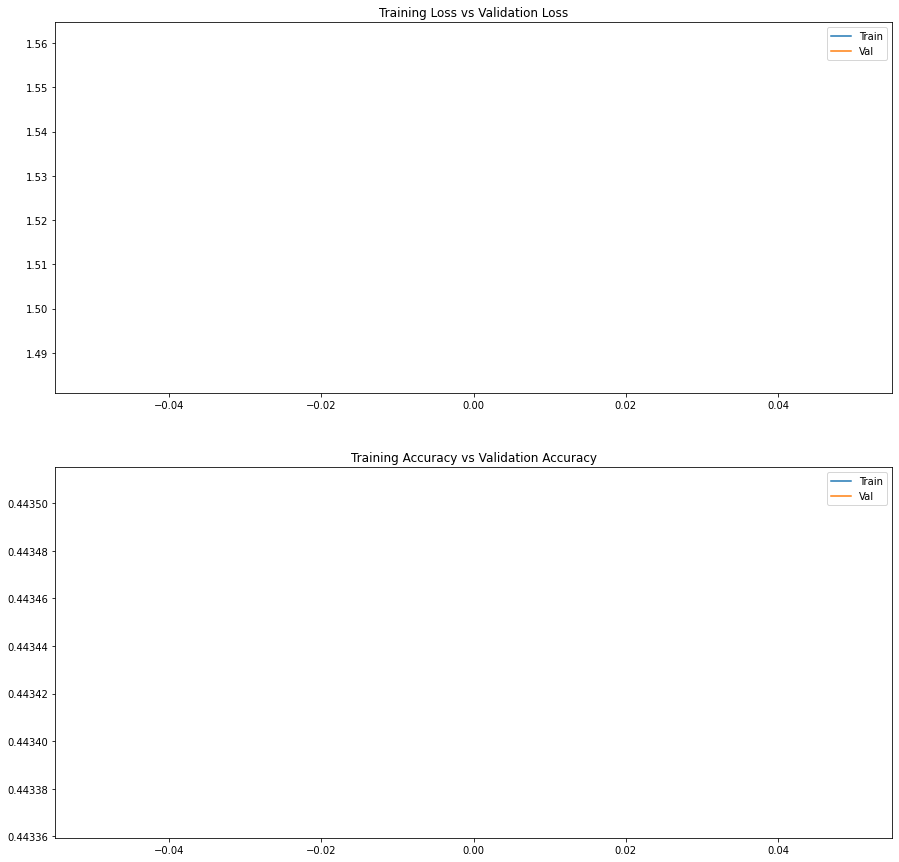

In [12]:
print(history.history['accuracy'])

fig, axs = plt.subplots(2, 1, figsize=(15,15))  
axs[0].plot(history.history['loss']) 
axs[0].plot(history.history['val_loss']) 
axs[0].title.set_text('Training Loss vs Validation Loss') 
axs[0].legend(['Train', 'Val'])  

axs[1].plot(history.history['accuracy']) 
axs[1].plot(history.history['val_accuracy']) 
axs[1].title.set_text('Training Accuracy vs Validation Accuracy') 
axs[1].legend(['Train', 'Val'])
plt.savefig('project2_simple_network.png')